## Clustering the Riders
This time with DBSCAN.

In [1]:
import sys
sys.path.append("..")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import umap
import umap.plot
import seaborn as sns
from scipy.stats import mode
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from src.dbops import fetch_riders, fetch_stages, assign_clusters
from src.kmeans_selection import PREPROCESSORS, SPECIALTIES

### Loading the Riders

In [3]:
project = ["name", "nationality", "weight", "height", "points"]
riders = fetch_riders(project=project)
riders = pd.json_normalize(riders)
riders.head()

,name,nationality,weight,height,points.classic,points.gc,points.tt,points.sprint,points.climber
0,david-zabriskie,United States,67.0,183.0,62,1058,3065,204,185
1,lance-armstrong,United States,72.0,178.0,3827,3642,3813,2732,1653
2,alexandre-vinokourov,Kazakhstan,68.0,177.0,3008,5726,4500,3510,3240
3,george-hincapie,United States,83.0,191.0,4618,2389,2331,4370,593
4,laszlo-bodrogi,France,NaN,187.0,828,1074,4949,796,76


### Exploring the Data

In [4]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1171 entries, 0 to 1170
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1171 non-null   object 
 1   nationality     1171 non-null   object 
 2   weight          932 non-null    float64
 3   height          939 non-null    float64
 4   points.classic  1171 non-null   int64  
 5   points.gc       1171 non-null   int64  
 6   points.tt       1171 non-null   int64  
 7   points.sprint   1171 non-null   int64  
 8   points.climber  1171 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 82.5+ KB


In [5]:
riders["nationality"].value_counts().head()

Italy          236
Spain          144
France         143
Belgium         85
Netherlands     63
Name: nationality, dtype: int64

In [6]:
riders.describe()

,weight,height,points.classic,points.gc,points.tt,points.sprint,points.climber
count,932.000000,939.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000
mean,68.057983,179.726305,994.624253,1108.163962,577.475662,1361.237404,675.163962
std,7.428277,6.302490,1413.888983,1359.737744,1053.506435,1941.494461,1132.370307
min,1.780000,159.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,64.000000,175.000000,235.000000,310.500000,45.000000,308.500000,91.500000
50%,68.000000,180.000000,537.000000,647.000000,172.000000,741.000000,275.000000
75%,73.000000,184.000000,1148.000000,1316.000000,606.000000,1568.500000,746.000000
max,94.000000,199.000000,15680.000000,12409.000000,10687.000000,22714.000000,13660.000000


### Applying DBSCAN Algorithm
#### Without Dimensionality Reduction

In [7]:
# Define model and do clustering
pipeline = Pipeline([
    ("preprocessor", PREPROCESSORS["numeric_percentage_std"]),
    ("dbscan", DBSCAN()),
])
pipeline.fit(riders)

riders["cluster"] = pipeline["dbscan"].labels_

In [8]:
# Count riders in each cluster
riders.groupby("cluster").agg({"name": "count"})

,name
cluster,
-1,1041
0,64
1,5
2,12
3,16
4,9
5,9
6,5
7,5


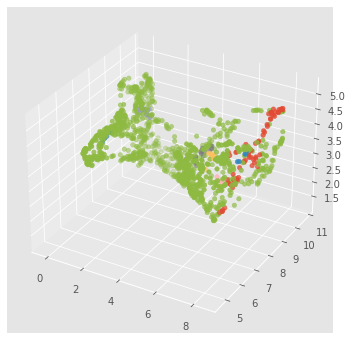

In [9]:
# UMAP Visualization
riders_umap = riders[["weight", "height"] + SPECIALTIES]

pipeline = Pipeline([
    ("preprocessor", PREPROCESSORS["numeric_percentage_std"]),
    ("umap", umap.UMAP(n_components=3))
])

embbeding = pipeline.fit_transform(riders_umap)

ax = plt.axes(projection="3d")
ax.scatter3D(
    embbeding[:, 0],
    embbeding[:, 1],
    embbeding[:, 2],
    c=[sns.color_palette(n_colors=20)[x] for x in riders["cluster"]]
)

#### Dimensionality Reduction with UMAP

In [202]:
# Define model and do clustering
riders.drop(columns="cluster", inplace=True)

reducer = umap.UMAP(n_components=3, n_neighbors=10, min_dist=0.06)

pipeline = Pipeline([
    ("preprocessor", PREPROCESSORS["numeric_percentage_std"]),
    ("umap", reducer),
    ("dbscan", DBSCAN(0.4)),
])
pipeline.fit(riders)

riders["cluster"] = pipeline["dbscan"].labels_

In [203]:
# Count riders in each cluster
riders.groupby("cluster").agg({"name": "count"})

,name
cluster,
-1,24
0,203
1,270
2,65
3,151
4,336
5,57
6,12
7,10


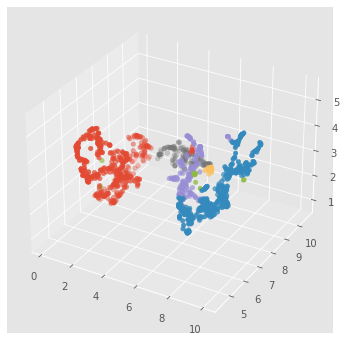

In [171]:
# UMAP Visualization
riders_umap = riders[["weight", "height"] + SPECIALTIES]

pipeline = Pipeline([
    ("preprocessor", PREPROCESSORS["numeric_percentage_std"]),
    ("umap", reducer)
])

embbeding = pipeline.fit_transform(riders_umap)

ax = plt.axes(projection="3d")
ax.scatter3D(
    embbeding[:, 0],
    embbeding[:, 1],
    embbeding[:, 2],
    c=[sns.color_palette(n_colors=20)[x] for x in riders["cluster"]]
)

### Looking at the Number of Stages by Clusters
#### Assigning the Stage to the Winner's Cluster

In [13]:
# Load stages
project = ["time_trial", "result"]
stages = fetch_stages(project=project)
stages = pd.DataFrame(stages)
stages.head()

,time_trial,result
0,True,"[david-zabriskie, lance-armstrong, alexandre-v..."
1,False,"[tom-boonen, thor-hushovd, robbie-mcewen, stua..."
2,False,"[tom-boonen, peter-wrolich, stuart-o-grady, be..."
3,False,"[robbie-mcewen, tom-boonen, thor-hushovd, stua..."
4,False,"[lorenzo-bernucci, alexandre-vinokourov, rober..."


In [14]:
stages["winner"] = stages["result"].transform(lambda x: x[0])
stages_winner = stages.merge(riders, left_on="winner", right_on="name")

In [15]:
stages_winner.groupby("cluster").agg({"winner": "count"})

,winner
cluster,
-1,28
0,1028


#### Assigning the Stage to the Mode of the First 10 Riders' Clusters

In [16]:
def get_clusters(result):
    clusters = []
    for rider in result:
        mask = (riders["name"] == rider)
        cluster = riders[mask]["cluster"]
        clusters.append(cluster)
    return np.array(clusters, dtype="uint8")

stages["result_clusters"] = stages["result"].transform(lambda result: get_clusters(result))

In [17]:
stages["cluster_mode"] = stages["result_clusters"].transform(lambda x: mode(x, axis=None).mode[0])

In [18]:
stages.groupby("cluster_mode").agg({"result": "count"})

,result
cluster_mode,
0,1056


Decision: assign the stage the cluster of the winner, as the classes are more balanced.

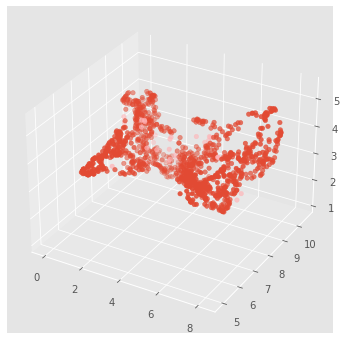

In [19]:
ax = plt.axes(projection="3d")
ax.scatter3D(
    embbeding[:, 0],
    embbeding[:, 1],
    embbeding[:, 2],
    c=[sns.color_palette()[x] for x in riders["cluster"]]
)

In [20]:
embbeding.shape

(1171, 3)

In [21]:
riders_umap = pipe.fit_transform(riders_umap)
embbeding = reducer.fit_transform(riders_umap)

NameError: name 'pipe' is not defined